✅ Loaded BTCUSDT_1h | 125195 rows
✅ Loaded ETHUSDT_1h | 125195 rows
✅ Loaded BTCUSDT_15m | 500754 rows
✅ Loaded ETHUSDT_15m | 500754 rows
✅ Loaded BTCUSDT_1h | 125195 rows
💾 Saved ..\outputs\features_BTCUSDT_1h.csv | 125175 rows | columns: 22
✅ Loaded ETHUSDT_1h | 125195 rows
💾 Saved ..\outputs\features_ETHUSDT_1h.csv | 125175 rows | columns: 22
✅ Loaded BTCUSDT_15m | 500754 rows
💾 Saved ..\outputs\features_BTCUSDT_15m.csv | 500730 rows | columns: 22
✅ Loaded ETHUSDT_15m | 500754 rows
💾 Saved ..\outputs\features_ETHUSDT_15m.csv | 500730 rows | columns: 22


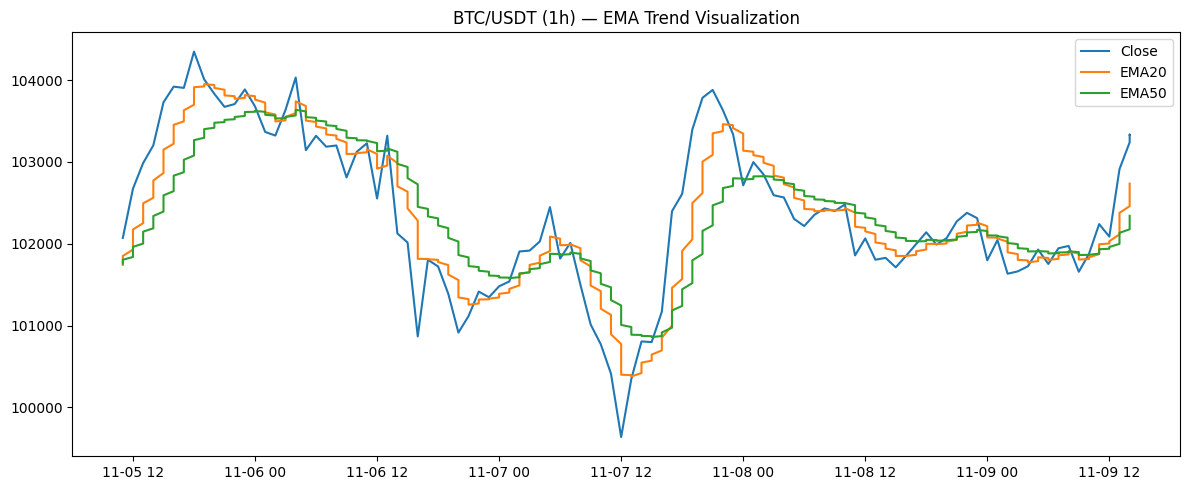


🎉 Feature Engineering Complete!
Files saved in ../outputs/:
   - features_BTCUSDT_15m.csv
   - features_BTCUSDT_1h.csv
   - features_ETHUSDT_15m.csv
   - features_ETHUSDT_1h.csv


In [4]:
# ================================================================
# PHASE 2: Feature Engineering for BTC & ETH Trading Data
# ================================================================

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ================================================================
# 1. Folder Setup
# ================================================================
DATA_RAW = os.path.join("..", "data_raw")
DATA_OUT = os.path.join("..", "outputs")
os.makedirs(DATA_OUT, exist_ok=True)

# ================================================================
# 2. Load Data
# ================================================================
def load_data(symbol_tf):
    path = os.path.join(DATA_RAW, f"raw_{symbol_tf}.csv")
    df = pd.read_csv(path, parse_dates=["time"])
    df = df.sort_values("time").reset_index(drop=True)
    print(f"✅ Loaded {symbol_tf} | {len(df)} rows")
    return df

btc_1h = load_data("BTCUSDT_1h")
eth_1h = load_data("ETHUSDT_1h")
btc_15m = load_data("BTCUSDT_15m")
eth_15m = load_data("ETHUSDT_15m")

# ================================================================
# 3. Technical Indicator Functions
# ================================================================
def add_indicators(df):
    df = df.copy()
    close = df["close"]
    high = df["high"]
    low = df["low"]
    volume = df["volume"]

    # ----- RSI -----
    delta = close.diff()
    gain = np.where(delta > 0, delta, 0)
    loss = np.where(delta < 0, -delta, 0)
    avg_gain = pd.Series(gain).rolling(14).mean()
    avg_loss = pd.Series(loss).rolling(14).mean()
    rs = avg_gain / avg_loss
    df["RSI"] = 100 - (100 / (1 + rs))

    # ----- MACD -----
    ema12 = close.ewm(span=12, adjust=False).mean()
    ema26 = close.ewm(span=26, adjust=False).mean()
    df["MACD"] = ema12 - ema26
    df["Signal"] = df["MACD"].ewm(span=9, adjust=False).mean()

    # ----- EMAs -----
    df["EMA20"] = close.ewm(span=20, adjust=False).mean()
    df["EMA50"] = close.ewm(span=50, adjust=False).mean()
    df["EMA200"] = close.ewm(span=200, adjust=False).mean()

    # ----- Bollinger Bands -----
    sma20 = close.rolling(20).mean()
    std20 = close.rolling(20).std()
    df["BB_Upper"] = sma20 + 2 * std20
    df["BB_Lower"] = sma20 - 2 * std20

    # ----- ATR (Volatility) -----
    tr1 = high - low
    tr2 = abs(high - close.shift())
    tr3 = abs(low - close.shift())
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    df["ATR"] = tr.rolling(14).mean()

    # ----- VWAP -----
    df["TP"] = (high + low + close) / 3
    df["Cum_Volume"] = volume.cumsum()
    df["Cum_VolPrice"] = (volume * df["TP"]).cumsum()
    df["VWAP"] = df["Cum_VolPrice"] / df["Cum_Volume"]

    # ----- Returns & Volatility -----
    df["Return_1"] = close.pct_change()
    df["Volatility_20"] = df["Return_1"].rolling(20).std() * np.sqrt(20)

    return df

# ================================================================
# 4. Market Regime Labeling
# ================================================================
def add_market_labels(df):
    df = df.copy()
    trend_strength = abs(df["EMA20"] - df["EMA200"]) / df["EMA200"]
    volatility = df["Volatility_20"]

    cond_trending = trend_strength > 0.02
    cond_volatile = volatility > volatility.quantile(0.8)

    df["Market_State"] = "Ranging"
    df.loc[cond_trending, "Market_State"] = "Trending"
    df.loc[cond_volatile, "Market_State"] = "Volatile"

    return df

# ================================================================
# 5. Combine Indicators + Labels
# ================================================================
def process_symbol(symbol_tf):
    df = load_data(symbol_tf)
    df = add_indicators(df)
    df = add_market_labels(df)
    df = df.dropna().reset_index(drop=True)
    out_path = os.path.join(DATA_OUT, f"features_{symbol_tf}.csv")
    df.to_csv(out_path, index=False)
    print(f"💾 Saved {out_path} | {len(df)} rows | columns: {len(df.columns)}")
    return df

btc_1h_feat = process_symbol("BTCUSDT_1h")
eth_1h_feat = process_symbol("ETHUSDT_1h")
btc_15m_feat = process_symbol("BTCUSDT_15m")
eth_15m_feat = process_symbol("ETHUSDT_15m")

# ================================================================
# 6. Quick Visualization
# ================================================================
plt.figure(figsize=(12, 5))
plt.plot(btc_1h_feat["time"].iloc[-500:], btc_1h_feat["close"].iloc[-500:], label="Close")
plt.plot(btc_1h_feat["time"].iloc[-500:], btc_1h_feat["EMA20"].iloc[-500:], label="EMA20")
plt.plot(btc_1h_feat["time"].iloc[-500:], btc_1h_feat["EMA50"].iloc[-500:], label="EMA50")
plt.title("BTC/USDT (1h) — EMA Trend Visualization")
plt.legend()
plt.tight_layout()
plt.show()

# ================================================================
# 7. Completion Summary
# ================================================================
print("\n🎉 Feature Engineering Complete!")
print("Files saved in ../outputs/:")
for f in os.listdir(DATA_OUT):
    if f.startswith("features_"):
        print("   -", f)
